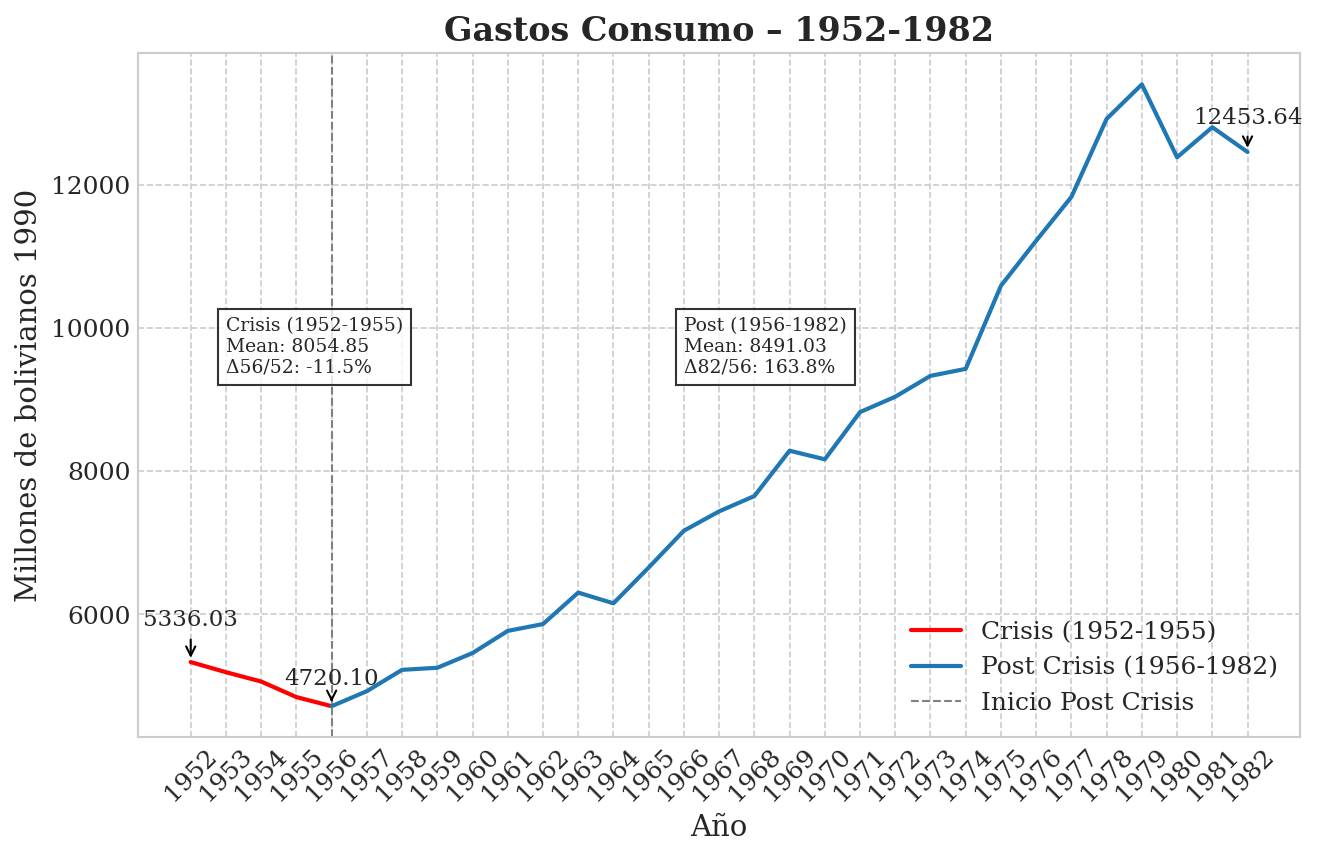

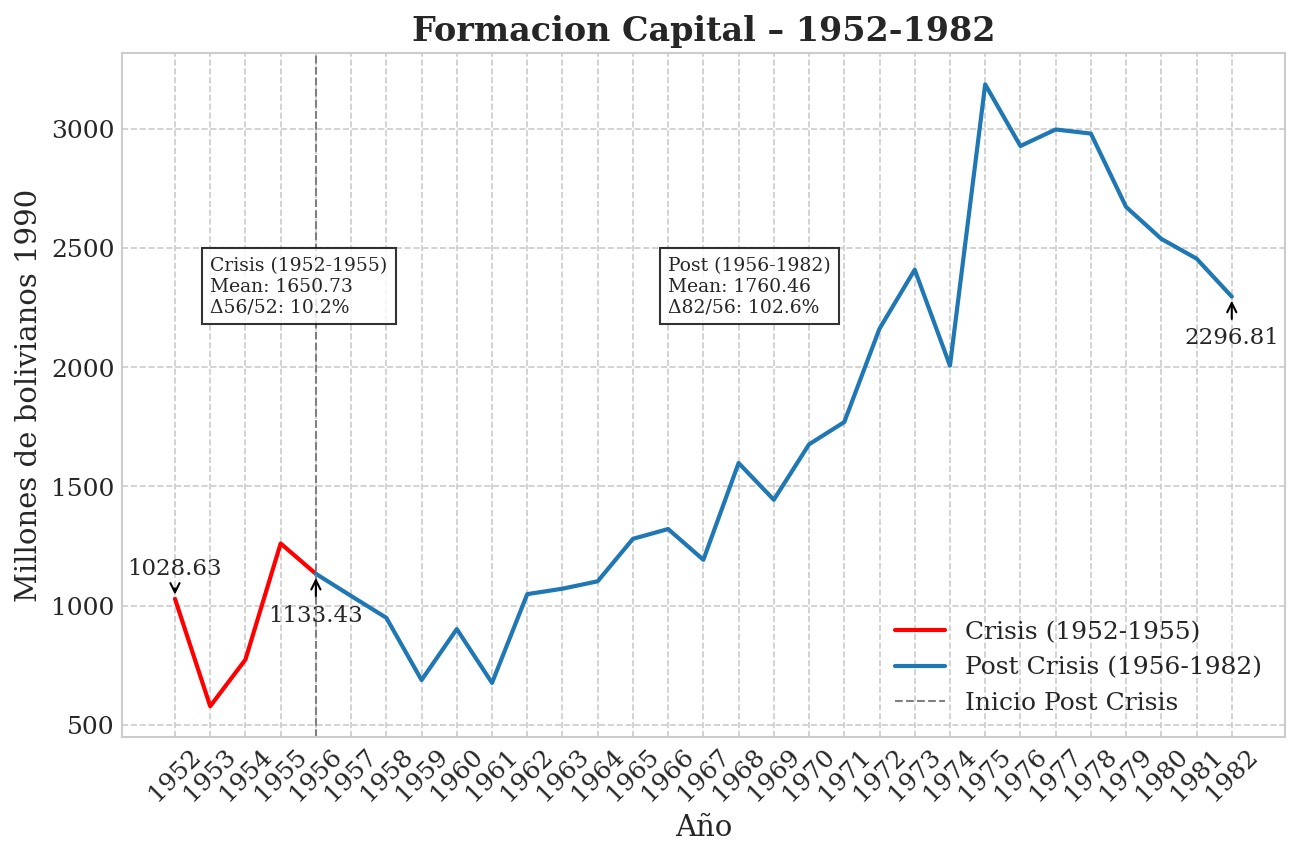

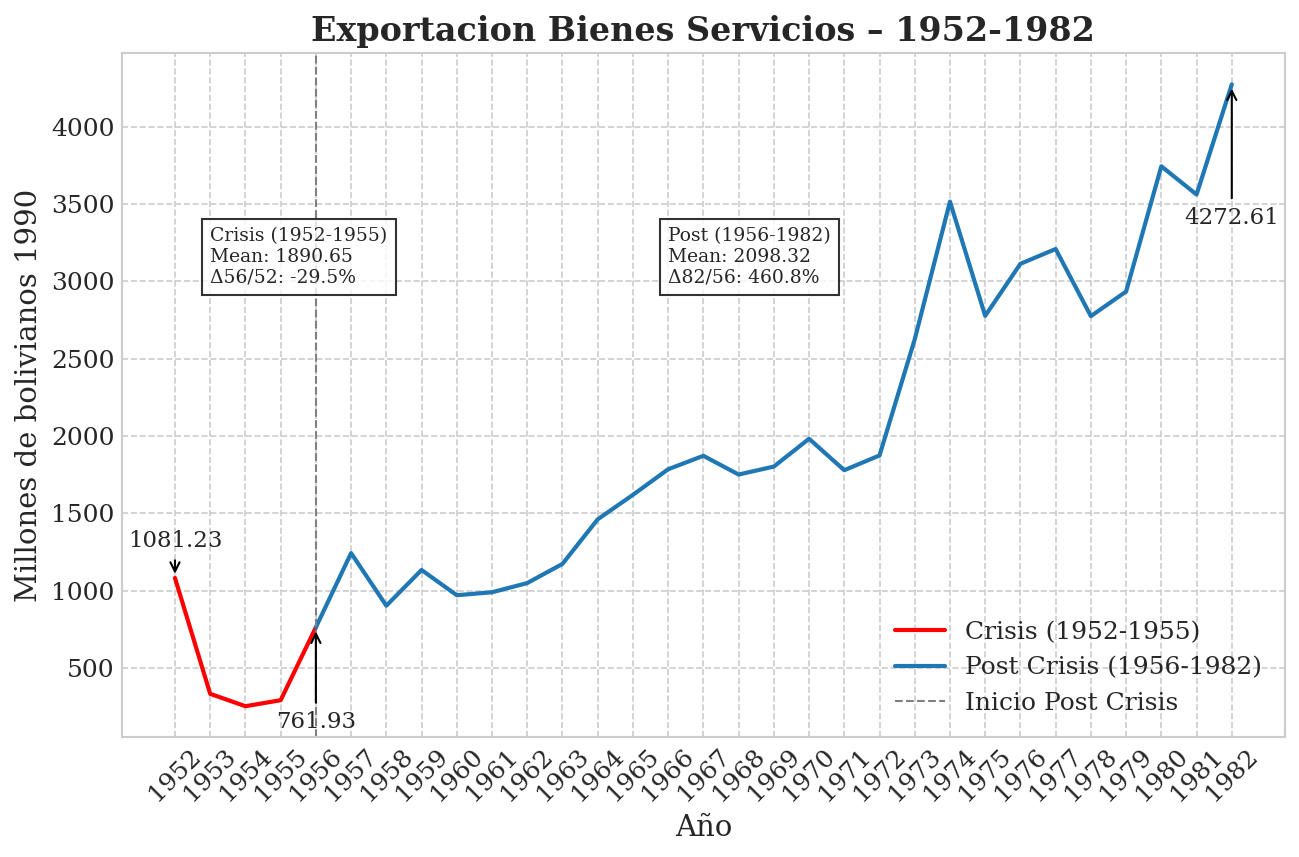

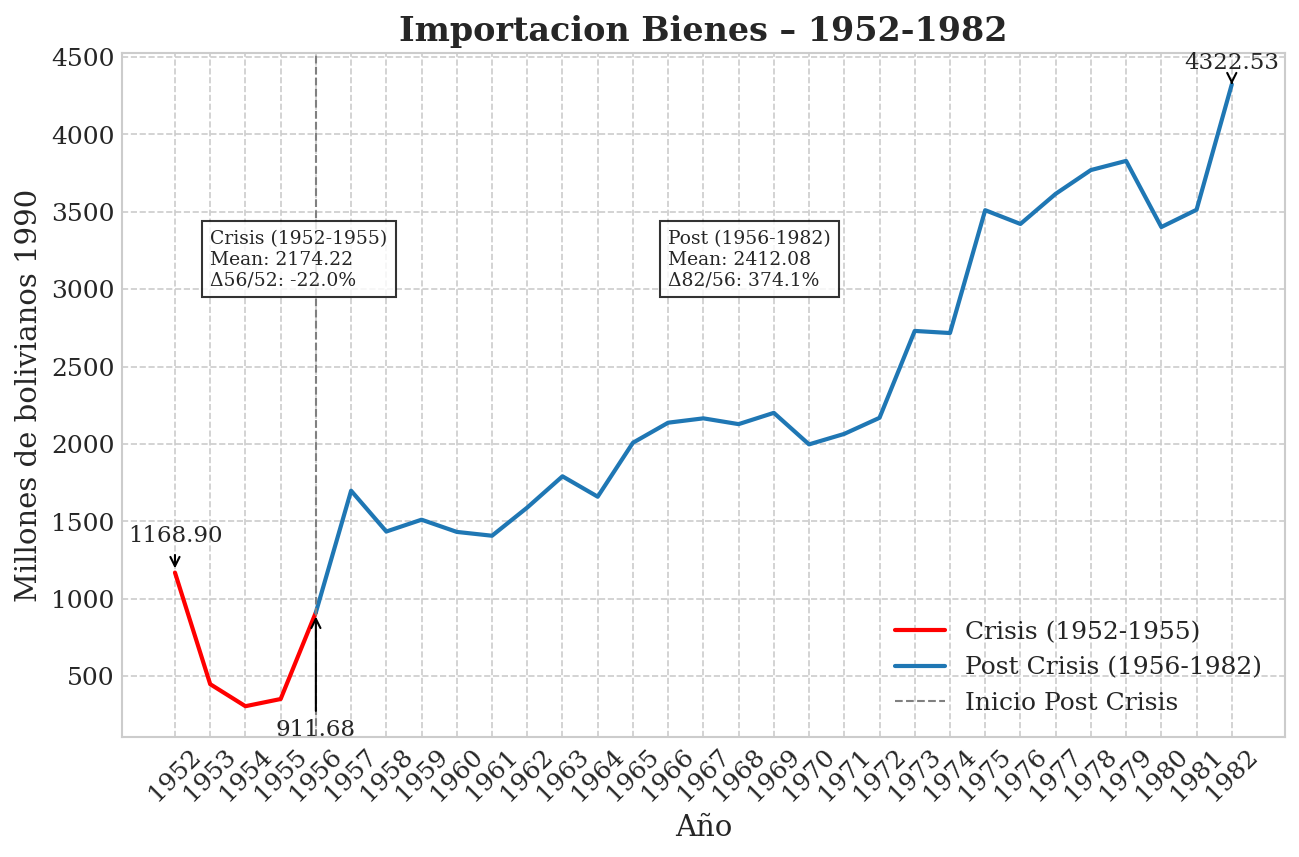

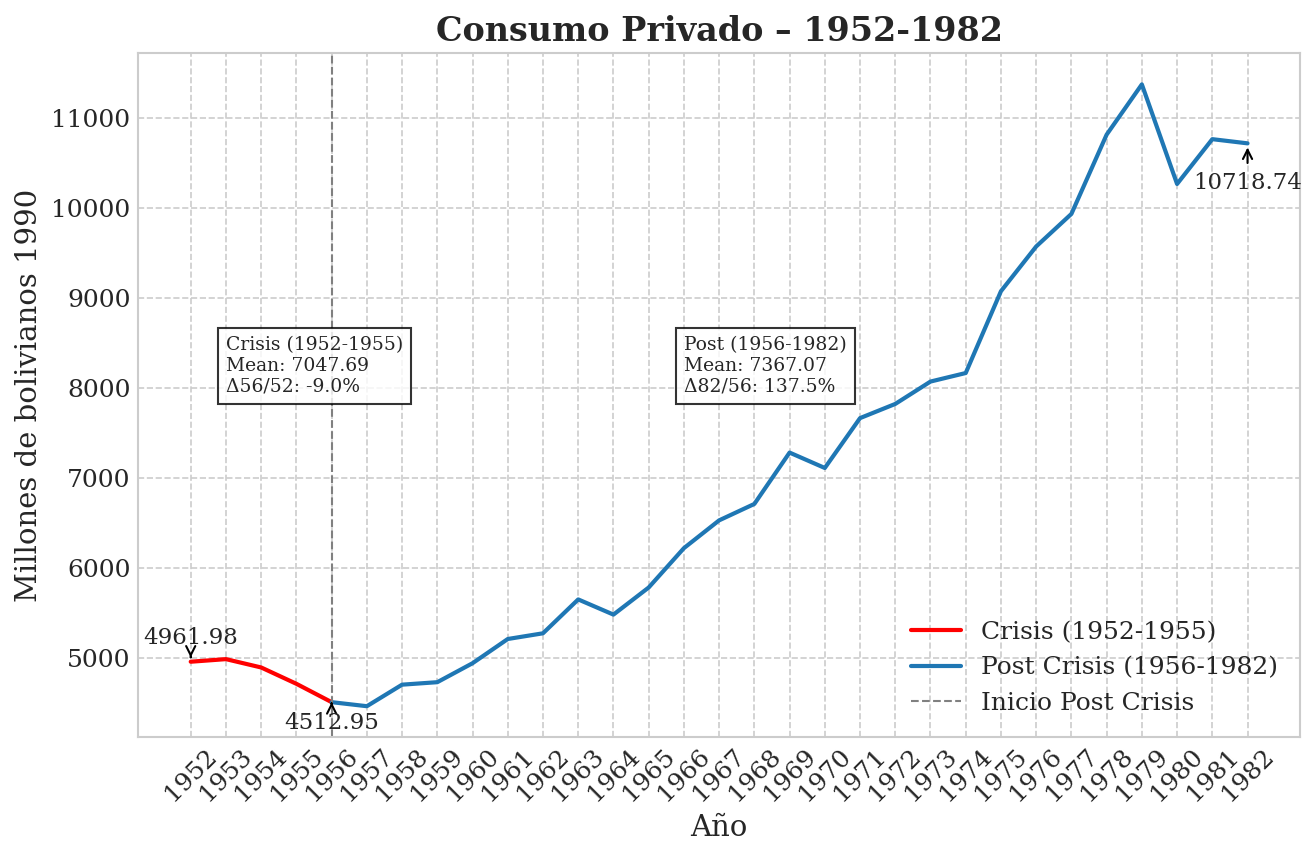

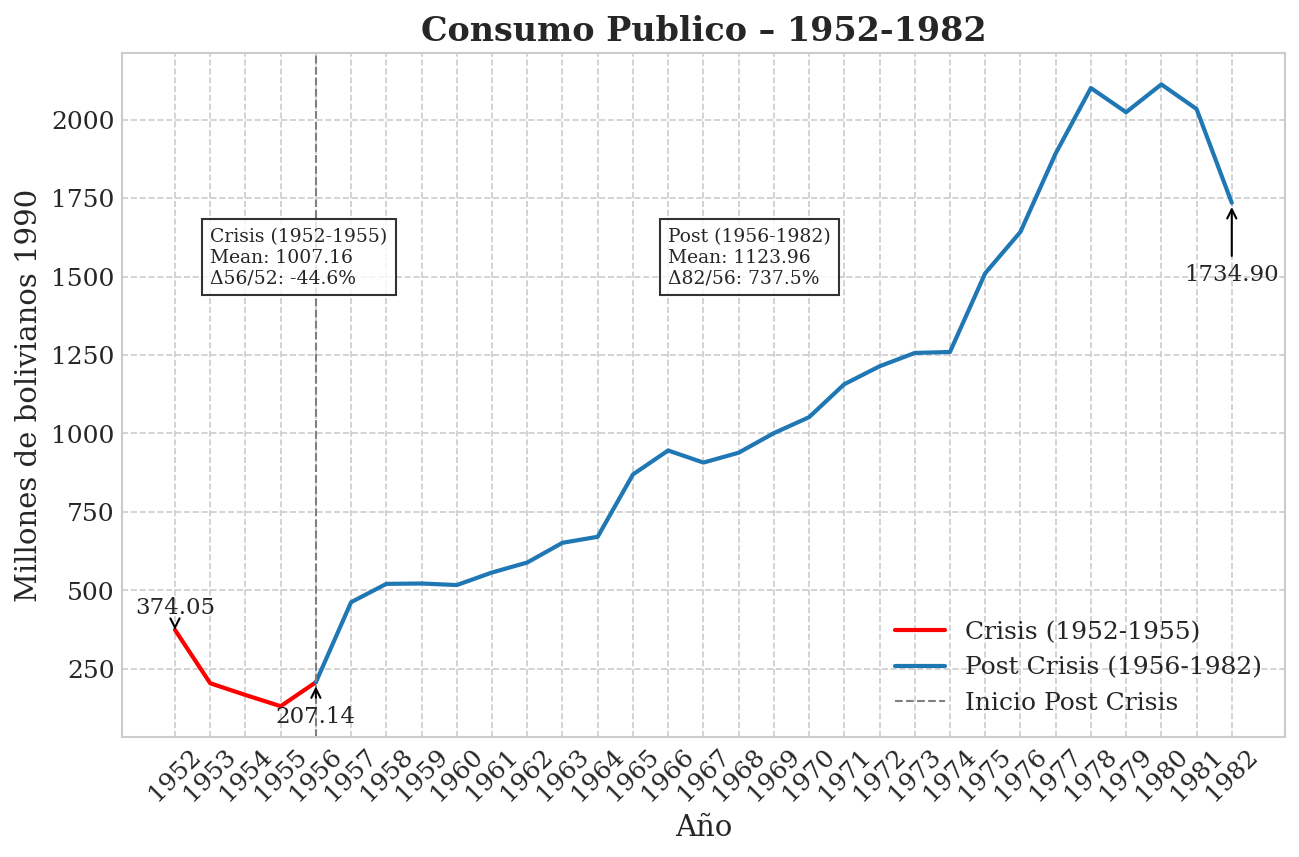

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os

# ------------------------------------------------------------------------------
# 1.  DIRECTORIOS
# ------------------------------------------------------------------------------
base_path      = "../../../assets/tesis/intervensionismo_estatal/serie_completa"
dir_completa   = os.path.join(base_path, "componentes_pib")
os.makedirs(dir_completa, exist_ok=True)

# ------------------------------------------------------------------------------
# 2.  ESTILO GRÁFICO PROFESIONAL
# ------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family'   : 'serif',
    'font.size'     : 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'figure.dpi'    : 150,
    'savefig.bbox'  : 'tight'
})

# ------------------------------------------------------------------------------
# 3.  CARGA DE DATOS
# ------------------------------------------------------------------------------
conn = sqlite3.connect('../../../db/proyectomacro.db')
df_pib = pd.read_sql_query("SELECT * FROM pib_real_gasto", conn)
conn.close()

df_pib.set_index('año', inplace=True)
df_pib = df_pib.loc[1952:1982]            # rango de interés
df_pib /= 1000                            # opcional: escalar a millones

# Componentes a graficar (excluimos la variable total)
componentes = [
    'gastos_consumo',
    'formacion_capital',
    'exportacion_bienes_servicios',
    'importacion_bienes',
    'consumo_privado',
    'consumo_publico'
]

# ------------------------------------------------------------------------------
# 4.  FUNCIÓN AUXILIAR PARA TEXTO DE ESTADÍSTICAS
# ------------------------------------------------------------------------------
def cuadro_estadisticas(serie):
    mean = serie.mean()
    g56  = (serie.loc[1956] - serie.loc[1952]) / serie.loc[1952] * 100
    return (f"Crisis (1952‑1955)\nMean: {mean:.2f}\n"
            f"Δ56/52: {g56:.1f}%")

def cuadro_estadisticas_post(serie):
    mean = serie.loc[1956:1982].mean()
    g56  = 0                                 # ya es el punto inicial post‑crisis
    g82  = (serie.loc[1982] - serie.loc[1956]) / serie.loc[1956] * 100
    return (f"Post (1956‑1982)\nMean: {mean:.2f}\n"
            f"Δ82/56: {g82:.1f}%")
# Antes del bucle, mapea componente → { año: (dx, dy), … }
annotation_offsets = {
    'gastos_consumo': {
        1952: (0, 500),
        1956: (0, 300),
        1982: (0, 400),
    },
    'formacion_capital': {
        1952: (0, 100),
        1956: (0, -200),
        1982: (0, -200),
    },
    'exportacion_bienes_servicios': {
        1952: (0, 200),
        1956: (0, -650),
        1982: (0, -900),
    },
    'importacion_bienes': {
        1952: (0, 200),
        1956: (0, -800),
        1982: (0, 100),
    },
    'consumo_privado': {
        1952: (0, 200),
        1956: (0, -300),
        1982: (0, -500),
    },
    'consumo_publico': {
        1952: (0, 50),
        1956: (0, -130),
        1982: (0, -250),
    },
}
años_para_anotaciones_localizacion={
    'gastos_consumo': 1966,
    'formacion_capital': 1966,
    'exportacion_bienes_servicios': 1966,
    'importacion_bienes': 1966,
    'consumo_privado': 1966,
    'consumo_publico': 1966,
}
# ------------------------------------------------------------------------------
# 5.  CREACIÓN DE GRÁFICAS
# ------------------------------------------------------------------------------
for col in componentes:
    serie = df_pib[col]
    fig, ax = plt.subplots(figsize=(10, 6))

    # Segmentos y colores
    ax.plot(serie.loc[1952:1956], color='red',     label='Crisis (1952‑1955)')
    ax.plot(serie.loc[1956:1982], color='#1f77b4', label='Post Crisis (1956‑1982)')

    # Línea vertical 1956
    ax.axvline(x=1956, color='gray', linestyle='--', linewidth=1, label='Inicio Post Crisis')

    # años clave
    for yr in (1952, 1956, 1982):
        val = serie.loc[yr]
        # offset por componente y año (o fallback a un delta vertical fijo)
        dx, dy = annotation_offsets.get(col, {}).get(yr, (0, val*0.05))
        ax.annotate(f"{val:.2f}",
                    xy=(yr, val),
                    xytext=(yr+dx, val+dy),
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    ha='center', fontsize=11)
    año=años_para_anotaciones_localizacion.get(col, 1970)
    # Cuadros de estadísticas
    ax.text(1953,  serie.max()*0.70, cuadro_estadisticas(serie),
            fontsize=9, bbox=dict(fc='white', alpha=0.8, ec='black'))
    ax.text(año,  serie.max()*0.70, cuadro_estadisticas_post(serie),
            fontsize=9, bbox=dict(fc='white', alpha=0.8, ec='black'))

    # Etiquetas y leyenda
    ax.set_title(f"{col.replace('_',' ').title()} – 1952‑1982", fontweight='bold')
    ax.set_xlabel("Año")
    ax.set_ylabel("Millones de bolivianos 1990")
    ax.legend()
    plt.xticks(df_pib.index, rotation=45)

    # Ajustes y guardado
    plt.subplots_adjust(top=0.88, bottom=0.12)
    plt.savefig(os.path.join(dir_completa, f"{col}.png"))
    plt.show()
    plt.close()
